## This nb borrowed lines from OpenAI and ChapGPT

In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel

In [2]:
import torchvision.transforms.functional as TF,torch.nn.functional as F
from miniai.datasets import *
from datasets import load_dataset,load_dataset_builder

In [3]:
from huggingface_hub import hf_hub_download
import json 

In [4]:
"GPU is there" if torch.cuda.is_available() else Exception("GPU is missing") 

'GPU is there'

Optional: Check if Container is paging

apt update && apt-get install sysstat && pidstat -r -d --human 3

### Loading Tiny-Imagenet

In [5]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [6]:
@inplace
def transformi(b): b[xl] = [TF.to_tensor(o)-0.0 for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=7)

In [7]:
dt = dls.train
xb,yb = next(iter(dt))

### Generate captions for CLIP to use

In [8]:
# load the files
fp_json_pos2idx = hf_hub_download(repo_id=name, filename="dataset_infos.json", repo_type="dataset")
fp_idx2human = hf_hub_download(repo_id=name, filename="classes.py", repo_type="dataset")

In [9]:
f = open(fp_json_pos2idx,) 
data_pos2idx = json.load(f) 
f.close() 

In [10]:
# Repo provided a variable called 'i2d'
exec(open(fp_idx2human).read()) 
# Let's rename this variable to something suitable for this notebook
idx2human = i2d

In [11]:
pos2idx = data_pos2idx['Maysee--tiny-imagenet']['features']['label']['names']

In [12]:
pos2human = [idx2human[v] for k,v in enumerate(pos2idx)]

In [13]:
pos2human[0:5]

['goldfish, Carassius auratus',
 'European fire salamander, Salamandra salamandra',
 'bullfrog, Rana catesbeiana',
 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 'American alligator, Alligator mississipiensis']

In [14]:
captions = ["A photo of a " + txt.split(",")[0] for txt in pos2human]

In [15]:
captions[0:5]

['A photo of a goldfish',
 'A photo of a European fire salamander',
 'A photo of a bullfrog',
 'A photo of a tailed frog',
 'A photo of a American alligator']

In [16]:
len(captions)

200

In [17]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)

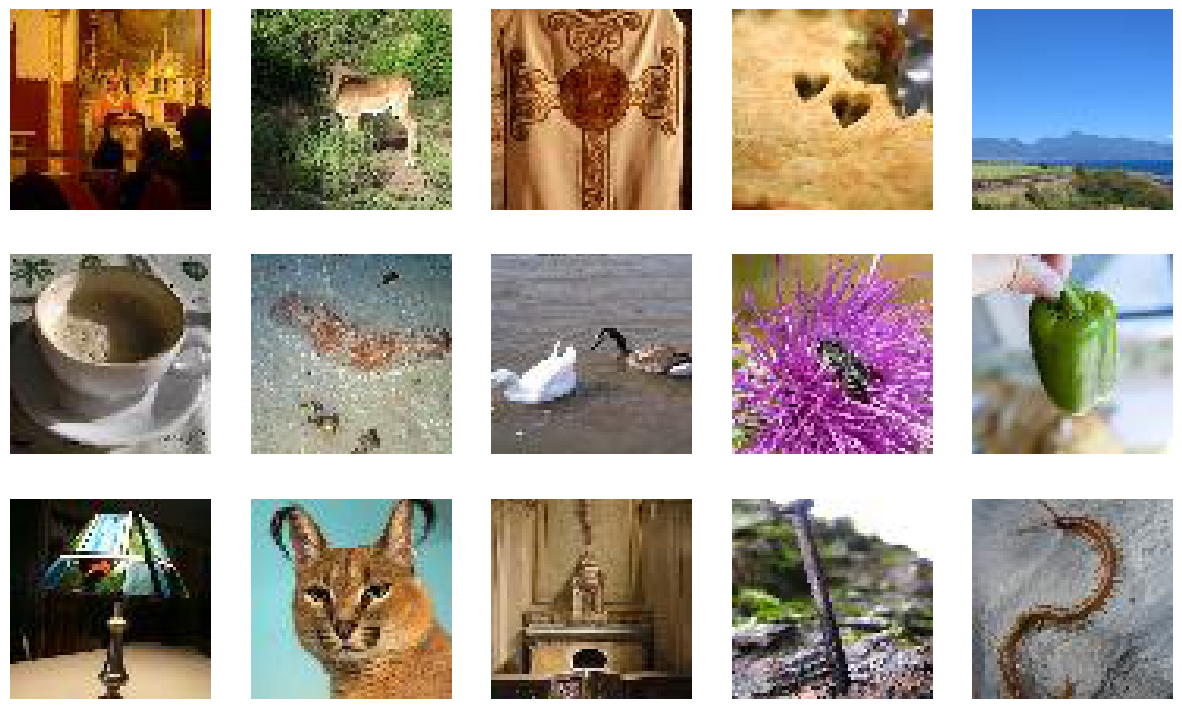

In [18]:
show_images(xb[0:15])

### Randomly choose an image to pass to CLIP

In [19]:
pos=(torch.rand(1)*15).round().int().item()
selected_image = xb[pos]

"do_rescale=False" is required for the next cell.
CLIP's predictions are worse by a big margin if input image is rescaled a second time. 


In [20]:
inputs = processor(text=captions, images=selected_image, return_tensors="pt", padding=True, do_rescale=False)
image_input = inputs["pixel_values"].to("cuda")
text_inputs = inputs["input_ids"].to("cuda")
attention_mask = inputs["attention_mask"].to("cuda")

<Axes: >

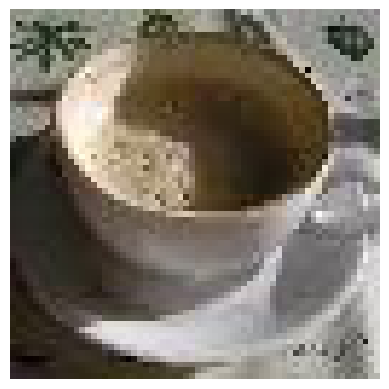

In [21]:
show_image(selected_image)

### CLIP: (img, text) -> (img_emb, text_emb)

In [22]:
with torch.no_grad():
    # Compute the image and text embeddings
    image_features = model.get_image_features(image_input)
    text_features = model.get_text_features(input_ids=text_inputs, attention_mask=attention_mask)

In [23]:
image_features.shape, text_features.shape

(torch.Size([1, 768]), torch.Size([200, 768]))

In [24]:
# Normalize the features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

### CLIP: dot product and find best 5 matches

In [25]:
# Compute similarity scores
similarity_scores = image_features @ text_features.T

# Get the index of the best matching text description
best_match_index = similarity_scores.argmax().item()

# Output the best matching text description
print(f"Best match: {captions[best_match_index]} (score: {similarity_scores[0, best_match_index]:.4f})")

Best match: A photo of a espresso (score: 0.2145)


In [26]:
vals, indx = similarity_scores[0].topk(5)
print("\nTop predictions:\n")
for value, index in zip(vals, indx):
    print(f"{captions[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

A photo of a espresso: 21.45%
A photo of a teapot: 17.90%
A photo of a beaker: 17.61%
A photo of a confectionery: 17.58%
A photo of a water jug: 17.43%


### True label

In [27]:
captions[yb[pos]]

'A photo of a espresso'